In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

!pip install keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

from sklearn.metrics import classification_report

Using Tensorflow version: 2.4.1


In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


## Predicting cellType

### Prepare train, test, validation dataset

In [5]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
Y = main_data['cellType']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.33, random_state=99)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=99)

trainY = trainY.ravel()
testY = testY.ravel()
valY = valY.ravel()

In [6]:
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(5304,)
(5304,)
(1326,)
(1326,)
(3266,)
(3266,)


In [7]:
trainX_img_list = trainX.tolist()
testX_img_list = testX.tolist()
valX_img_list = valX.tolist()

In [8]:
def create_img_dataset(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [9]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
# Khang desktop: C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images
# Khang laptop: C:\Users\Laptop\Desktop\RMIT\Cloud-GitHub\Minh\ML\Asm\ASM2\patch_images
path = r"C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images"

trainX_img = create_img_dataset(path, trainX_img_list)
testX_img = create_img_dataset(path, testX_img_list)
valX_img = create_img_dataset(path, valX_img_list)

Extracting Image Progress:  25%|██▍       | 803/3266 [00:00<00:00, 7971.66it/s]

Successfully import images!


Extracting Image Progress:  61%|██████    | 809/1326 [00:00<00:00, 8031.30it/s]

Successfully import images!


Extracting Image Progress: 100%|██████████| 1326/1326 [00:00<00:00, 7961.34it/s]

Successfully import images!


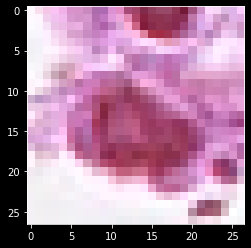

In [10]:
plt.imshow(trainX_img[0])

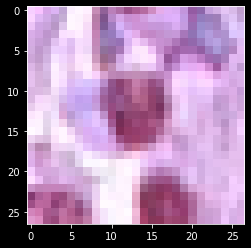

In [11]:
plt.imshow(testX_img[0])

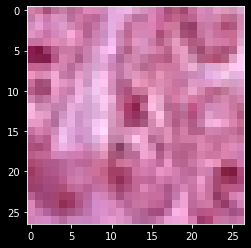

In [12]:
plt.imshow(valX_img[0])

### Build model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=trainX_img.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

## Simple CNN

In [13]:
model = Sequential()
model.add(Conv2D(32,3,padding='same', activation='relu', input_shape=trainX_img.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation="softmax"))

In [14]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.000001)
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0

In [15]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True, 
                                   rotation_range=20, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest', 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2)

train_it = train_datagen.flow(trainX_img, trainY)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

hist = model.fit(trainX_img, trainY, 
                 validation_data=(valX_img, valY),
                 batch_size=64, 
                 epochs=200, 
                 verbose=1)

Epoch 1/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9628 - accuracy: 0.6126 - val_loss: 0.9706 - val_accuracy: 0.6192
Epoch 2/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9662 - accuracy: 0.6052 - val_loss: 0.9702 - val_accuracy: 0.6199
Epoch 3/200
83/83 [==============================] - 2s 18ms/step - loss: 0.9605 - accuracy: 0.6167 - val_loss: 0.9698 - val_accuracy: 0.6222
Epoch 4/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9619 - accuracy: 0.6088 - val_loss: 0.9694 - val_accuracy: 0.6214
Epoch 5/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9604 - accuracy: 0.6118 - val_loss: 0.9689 - val_accuracy: 0.6214
Epoch 6/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9584 - accuracy: 0.6175 - val_loss: 0.9684 - val_accuracy: 0.6207
Epoch 7/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9600 - accuracy: 0.6103 - val_loss: 0.9680 - val_accuracy: 0.6229
Epoch 

83/83 [==============================] - 2s 20ms/step - loss: 0.9332 - accuracy: 0.6241 - val_loss: 0.9434 - val_accuracy: 0.6350
Epoch 59/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9375 - accuracy: 0.6263 - val_loss: 0.9431 - val_accuracy: 0.6335
Epoch 60/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9324 - accuracy: 0.6193 - val_loss: 0.9427 - val_accuracy: 0.6335
Epoch 61/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9326 - accuracy: 0.6252 - val_loss: 0.9420 - val_accuracy: 0.6365
Epoch 62/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9304 - accuracy: 0.6205 - val_loss: 0.9417 - val_accuracy: 0.6357
Epoch 63/200
83/83 [==============================] - 2s 21ms/step - loss: 0.9332 - accuracy: 0.6286 - val_loss: 0.9412 - val_accuracy: 0.6357
Epoch 64/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9302 - accuracy: 0.6254 - val_loss: 0.9407 - val_accuracy: 0.6380
Epoch 65/200

83/83 [==============================] - 2s 19ms/step - loss: 0.9126 - accuracy: 0.6406 - val_loss: 0.9198 - val_accuracy: 0.6456
Epoch 116/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9089 - accuracy: 0.6350 - val_loss: 0.9194 - val_accuracy: 0.6456
Epoch 117/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9089 - accuracy: 0.6405 - val_loss: 0.9190 - val_accuracy: 0.6463
Epoch 118/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9089 - accuracy: 0.6374 - val_loss: 0.9187 - val_accuracy: 0.6478
Epoch 119/200
83/83 [==============================] - 2s 20ms/step - loss: 0.9086 - accuracy: 0.6425 - val_loss: 0.9183 - val_accuracy: 0.6463
Epoch 120/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9055 - accuracy: 0.6388 - val_loss: 0.9179 - val_accuracy: 0.6463
Epoch 121/200
83/83 [==============================] - 2s 19ms/step - loss: 0.9021 - accuracy: 0.6454 - val_loss: 0.9174 - val_accuracy: 0.6463
Epoch 

Epoch 172/200
83/83 [==============================] - 2s 21ms/step - loss: 0.8885 - accuracy: 0.6525 - val_loss: 0.8986 - val_accuracy: 0.6531
Epoch 173/200
83/83 [==============================] - 2s 20ms/step - loss: 0.8860 - accuracy: 0.6550 - val_loss: 0.8983 - val_accuracy: 0.6561
Epoch 174/200
83/83 [==============================] - 2s 20ms/step - loss: 0.8851 - accuracy: 0.6561 - val_loss: 0.8979 - val_accuracy: 0.6561
Epoch 175/200
83/83 [==============================] - 2s 21ms/step - loss: 0.8883 - accuracy: 0.6514 - val_loss: 0.8977 - val_accuracy: 0.6569
Epoch 176/200
83/83 [==============================] - 2s 20ms/step - loss: 0.8872 - accuracy: 0.6523 - val_loss: 0.8972 - val_accuracy: 0.6561
Epoch 177/200
83/83 [==============================] - 2s 21ms/step - loss: 0.8844 - accuracy: 0.6523 - val_loss: 0.8968 - val_accuracy: 0.6561
Epoch 178/200
83/83 [==============================] - 2s 21ms/step - loss: 0.8820 - accuracy: 0.6604 - val_loss: 0.8964 - val_accuracy:

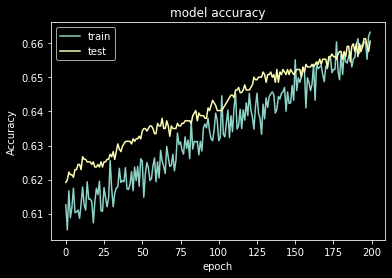

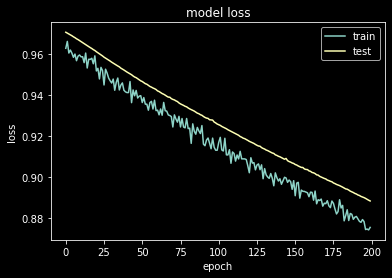

In [21]:
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [22]:
predictions = model.predict_classes(testX_img)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(testY, predictions, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 0       0.57      0.50      0.53       633
     Class 1       0.55      0.72      0.62       838
     Class 2       0.78      0.92      0.84      1349
     Class 3       0.80      0.02      0.04       446

    accuracy                           0.66      3266
   macro avg       0.67      0.54      0.51      3266
weighted avg       0.68      0.66      0.62      3266

